In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_percentage_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [2]:
# Load the training data
file_path = 'train.csv'
train_data = pd.read_csv(file_path)

In [3]:
train_data.head()

,volume_kg,distribution_channel,customer,brand,channel,store_format,category,year,month
0,460.026585,0,1,1,FOOD SERVICE,3,3,2010,1
1,456.944328,0,1,1,FOOD SERVICE,3,3,2010,2
2,926.790243,0,1,1,FOOD SERVICE,3,3,2010,3
3,762.549167,0,1,1,FOOD SERVICE,3,3,2010,4
4,1132.060704,0,1,1,FOOD SERVICE,3,3,2010,5


In [4]:
train_data.describe()

,volume_kg,distribution_channel,customer,brand,store_format,category,year,month
count,5793.000000,5793.000000,5793.000000,5793.000000,5793.000000,5793.000000,5793.000000,5793.000000
mean,32608.129946,0.446401,7.834973,1.309684,2.493009,8.257207,2014.740031,6.373036
std,78288.007176,0.497162,4.152610,0.775179,0.609259,2.534798,2.985650,3.474673
min,0.000000,0.000000,1.000000,0.000000,1.000000,3.000000,2010.000000,1.000000
25%,1522.525571,0.000000,5.000000,1.000000,2.000000,6.000000,2012.000000,3.000000
50%,5773.631475,0.000000,8.000000,1.000000,3.000000,10.000000,2015.000000,6.000000
75%,27444.738749,1.000000,12.000000,2.000000,3.000000,10.000000,2017.000000,9.000000
max,671060.029704,1.000000,15.000000,3.000000,3.000000,10.000000,2020.000000,12.000000


In [5]:
train_data.isnull().sum()

volume_kg               0
distribution_channel    0
customer                0
brand                   0
channel                 0
store_format            0
category                0
year                    0
month                   0
dtype: int64

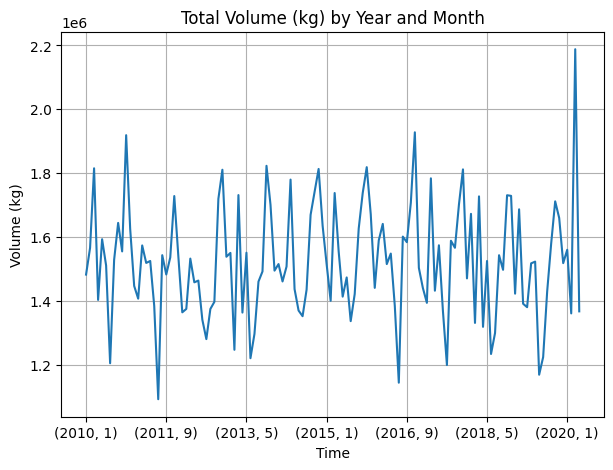

In [7]:
# Time series plots for volume_kg by year and month
plt.figure(figsize=(7, 5))
train_data.groupby(['year', 'month'])['volume_kg'].sum().plot()
plt.title('Total Volume (kg) by Year and Month')
plt.xlabel('Time')
plt.ylabel('Volume (kg)')
plt.grid(True)
plt.show()

In [8]:
# Aggregate the volume_kg by year and month
time_series_data = train_data.groupby(['year', 'month'])['volume_kg'].sum().reset_index()

In [9]:
# Convert to datetime
time_series_data['date'] = pd.to_datetime(time_series_data[['year', 'month']].assign(day=1))
time_series_data.set_index('date', inplace=True)

<Figure size 1400x1000 with 0 Axes>

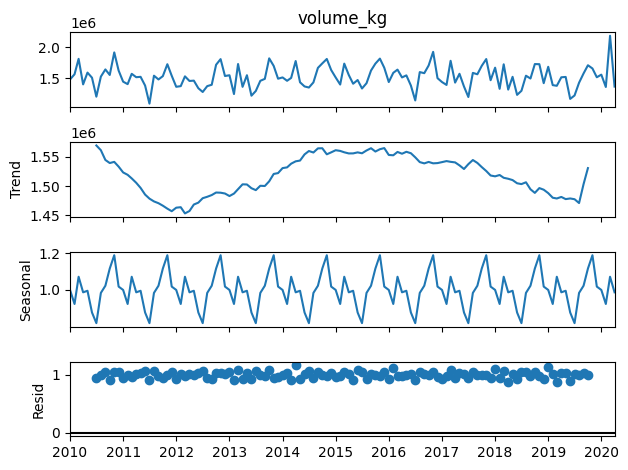

In [10]:
# Decompose the time series
decomposition = seasonal_decompose(time_series_data['volume_kg'], model='multiplicative', period=12)

# Plot the decomposition
plt.figure(figsize=(14, 10))
decomposition.plot()
plt.show()

In [11]:
# Feature Engineering
# Create time-based features
train_data['date'] = pd.to_datetime(train_data.assign(day=1)[['year', 'month', 'day']])
train_data['month'] = train_data['date'].dt.month
train_data['quarter'] = train_data['date'].dt.quarter
train_data['year'] = train_data['date'].dt.year

# Create lag features
train_data['lag_1'] = train_data.groupby(['distribution_channel', 'customer', 'brand', 'channel', 'store_format', 'category'])['volume_kg'].shift(1)
train_data['lag_12'] = train_data.groupby(['distribution_channel', 'customer', 'brand', 'channel', 'store_format', 'category'])['volume_kg'].shift(12)

# Create rolling statistics
train_data['rolling_mean_3'] = train_data.groupby(['distribution_channel', 'customer', 'brand', 'channel', 'store_format', 'category'])['volume_kg'].transform(lambda x: x.rolling(window=3).mean())
train_data['rolling_std_3'] = train_data.groupby(['distribution_channel', 'customer', 'brand', 'channel', 'store_format', 'category'])['volume_kg'].transform(lambda x: x.rolling(window=3).std())

In [12]:
# Drop rows with NaN values created by shifting
train_data.dropna(inplace=True)

In [13]:
train_data.head()

,volume_kg,distribution_channel,customer,brand,channel,store_format,category,year,month,date,quarter,lag_1,lag_12,rolling_mean_3,rolling_std_3
12,461.730869,0,1,1,FOOD SERVICE,3,3,2011,1,2011-01-01,1,537.456894,460.026585,863.448287,631.350689
13,838.724689,0,1,1,FOOD SERVICE,3,3,2011,2,2011-02-01,1,461.730869,456.944328,612.637484,199.424612
14,459.653661,0,1,1,FOOD SERVICE,3,3,2011,3,2011-03-01,1,838.724689,926.790243,586.703073,218.259593
15,1085.028740,0,1,1,FOOD SERVICE,3,3,2011,4,2011-04-01,2,459.653661,762.549167,794.469030,315.027649
16,454.674555,0,1,1,FOOD SERVICE,3,3,2011,5,2011-05-01,2,1085.028740,1132.060704,666.452319,362.506363


In [14]:
# Select one series for initial model evaluation
series_id = (0, 1, 1, 'FOOD SERVICE', 3, 3)
series_data = train_data[(train_data['distribution_channel'] == series_id[0]) & 
                         (train_data['customer'] == series_id[1]) &
                         (train_data['brand'] == series_id[2]) &
                         (train_data['channel'] == series_id[3]) &
                         (train_data['store_format'] == series_id[4]) &
                         (train_data['category'] == series_id[5])]

In [15]:
# Prepare the time series data
series_data.set_index('date', inplace=True)
series_data = series_data.asfreq('MS')  # Ensure the data is monthly start

In [16]:
# Train-test split
train_size = int(len(series_data) * 0.8)
train_series, test_series = series_data.iloc[:train_size], series_data.iloc[train_size:]

In [17]:
# Fit ARIMA model
arima_model = ARIMA(train_series['volume_kg'], order=(1, 1, 1))
arima_fit = arima_model.fit()

In [18]:
# Forecast
forecast_steps = len(test_series)
forecast = arima_fit.forecast(steps=forecast_steps)

In [19]:
# Evaluate the model
mape = mean_absolute_percentage_error(test_series['volume_kg'], forecast)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is depreca

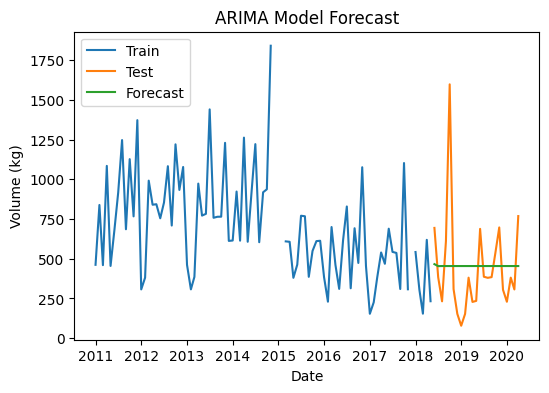

In [22]:
# Plot the results
plt.figure(figsize=(6, 4))
plt.plot(train_series['volume_kg'], label='Train')
plt.plot(test_series['volume_kg'], label='Test')
plt.plot(test_series.index, forecast, label='Forecast')
plt.legend()
plt.title('ARIMA Model Forecast')
plt.xlabel('Date')
plt.ylabel('Volume (kg)')
plt.show()

In [23]:
print(f'MAPE: {mape}')

MAPE: 0.7717520163916142


In [24]:
# Impute missing values using forward-fill method
series_data['volume_kg'].fillna(method='ffill', inplace=True)

/var/folders/4j/lfyylb311zz43rwm57kmmfpw0000gn/T/ipykernel_15853/2976197277.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  series_data['volume_kg'].fillna(method='ffill', inplace=True)


In [25]:
# Define a function to perform time series cross-validation
def robust_time_series_cv(data, order, seasonal_order, n_splits=5):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    mape_scores = []

    for train_index, test_index in tscv.split(data):
        train, test = data.iloc[train_index], data.iloc[test_index]
        model = SARIMAX(train['volume_kg'], order=order, seasonal_order=seasonal_order)
        model_fit = model.fit(disp=False)
        forecast = model_fit.forecast(steps=len(test)).fillna(0)  # Handle NaN in forecast
        mape = mean_absolute_percentage_error(test['volume_kg'].fillna(0), forecast)
        mape_scores.append(mape)

    return mape_scores

In [26]:
# Define the SARIMA model order
order = (1, 1, 1)
seasonal_order = (1, 1, 1, 12)  # Considering yearly seasonality

In [27]:
# Perform robust time series cross-validation
robust_mape_scores = robust_time_series_cv(series_data, order, seasonal_order)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse

In [28]:
# Average MAPE score
robust_average_mape = sum(robust_mape_scores) / len(robust_mape_scores)
print(f'Average MAPE: {robust_average_mape}')


Average MAPE: 0.5444862707737026


In [29]:
# Define a function to train and forecast using SARIMA for each series
def forecast_series(data, series_id, order, seasonal_order, forecast_steps=4):
    # Filter data for the specific series
    series_data = data[(data['distribution_channel'] == series_id[0]) & 
                       (data['customer'] == series_id[1]) &
                       (data['brand'] == series_id[2]) &
                       (data['channel'] == series_id[3]) &
                       (data['store_format'] == series_id[4]) &
                       (data['category'] == series_id[5])]

    # Prepare the time series data
    series_data.set_index('date', inplace=True)
    series_data = series_data.asfreq('MS')  # Ensure the data is monthly start

    # Impute missing values using forward-fill method
    series_data['volume_kg'].fillna(method='ffill', inplace=True)

    # Train SARIMA model
    model = SARIMAX(series_data['volume_kg'], order=order, seasonal_order=seasonal_order)
    model_fit = model.fit(disp=False)

    # Forecast next 4 months
    forecast = model_fit.forecast(steps=forecast_steps).fillna(0)
    
    return forecast

In [31]:
# List of unique series IDs
unique_series_ids = train_data[['distribution_channel', 'customer', 'brand', 'channel', 'store_format', 'category']].drop_duplicates()

# Generate forecasts for all series
forecasts = {}
for idx, row in unique_series_ids.iterrows():
    series_id = tuple(row)
    forecast = forecast_series(train_data, series_id, order, seasonal_order)
    forecasts[series_id] = forecast

# Format the forecasts for submission
forecast_list = []
for series_id, forecast in forecasts.items():
    for i, volume in enumerate(forecast):
        year = 2021  # Assuming forecasts start from January 2021
        month = i + 1
        id_str = f"{year}_{month}_{series_id[0]}_{series_id[1]}_{series_id[2]}_{series_id[3]}_{series_id[4]}_{series_id[5]}"
        forecast_list.append({'id': id_str, 'volume_kg': volume})

forecast_df = pd.DataFrame(forecast_list)
print(forecast_df.head())

/var/folders/4j/lfyylb311zz43rwm57kmmfpw0000gn/T/ipykernel_15853/3333045712.py:16: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  series_data['volume_kg'].fillna(method='ffill', inplace=True)
/var/folders/4j/lfyylb311zz43rwm57kmmfpw0000gn/T/ipykernel_15853/3333045712.py:16: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  series_data['volume_kg'].fillna(method='ffill', inplace=True)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/var/folders/4j/lfyylb311zz43rwm57kmmfpw0000gn/T/ipykernel_15853/3333045712.py:16: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Us

                              id    volume_kg
0  2021_1_0_1_1_FOOD SERVICE_3_3   213.927437
1  2021_2_0_1_1_FOOD SERVICE_3_3   485.826394
2  2021_3_0_1_1_FOOD SERVICE_3_3   540.481828
3  2021_4_0_1_1_FOOD SERVICE_3_3   390.946378
4  2021_1_0_1_1_FOOD SERVICE_3_6  5623.151197
